In [236]:
import pandas as pd
import numpy as np
import pickle
import matplotlib as plt
import seaborn as sns
%matplotlib inline

In [237]:
# Importing more complete IMDB csv file.
imdb_df = pd.read_csv('zippedData/imdb.movies.csv.zip')

# Dropping columns that won't be used.
imdb_df.drop(columns=['original_title', 'year', 'language', 'actors', 'description', 'avg_vote',\
                      'votes', 'production_company'], inplace=True)

# Renaming and simplifying column names to be more descriptive.
new_column_list = ['imdb_id', 'title', 'release_date', 'genre', 'duration', 'country', 'director',\
                   'writer', 'budget', 'domestic_income', 'worldwide_income', 'metascore',\
                   'imdb_user_score', 'imdb_critic_score']
imdb_df.columns = new_column_list

In [238]:
# Convert release date to datetime object. If date only contains year, defaulting to January 1st.
imdb_df.release_date = pd.to_datetime(imdb_df.release_date)

# Filter out movies without a release date and made before 1990.
imdb_df.drop(imdb_df[imdb_df['release_date'].dt.year < 1990].index, inplace=True)

# Filter out movies made outside the USA.
imdb_df.drop(imdb_df[imdb_df['country'] != 'USA'].index, inplace=True)

In [239]:
# Drop country, director, and writer columns.
imdb_df.drop(columns=['country', 'director', 'writer'], inplace=True)

# Filter out null values for budget and domestic_income.
imdb_df.dropna(subset=['budget'], inplace=True)
imdb_df.dropna(subset=['domestic_income'], inplace=True)

In [240]:
# Drop critic ratings due to assumption that it is not valuable.
imdb_df = imdb_df.drop(columns=['metascore', 'imdb_critic_score'])

# Filter out 5 entries without an imdb user score.
imdb_df.dropna(subset=['imdb_user_score'], inplace=True)

In [241]:
# Import metacritic userscore to combine with imdb user score.
metacritic_df = pd.read_csv('zippedData/metacritic_movies.csv')
metacritic_df.drop(columns=['release_date', 'genre', 'meta_mixed', 'meta_negative', 'meta_positive', 'metascore',\
                           'user_mixed', 'user_negative', 'user_positive'], inplace=True)

# Rename columns to align with movies_df.
metacritic_df.columns = ['title', 'metacritic_user_score']

In [242]:
# Merge metacritic userscore into movies_df based on titles
movies_df = pd.merge(imdb_df, metacritic_df, left_on='title', right_on='title', how='left')

In [243]:
# Drop dupliace entries based on title
movies_df.drop_duplicates(subset='title', inplace=True)

In [244]:
# Replace null values and 'tbd' metacritic user scores into 0 integer.
movies_df['metacritic_user_score'] = movies_df['metacritic_user_score'].replace('tbd', '0', regex=True)
movies_df['metacritic_user_score'] = movies_df['metacritic_user_score'].replace('0', 0.0, regex=True)
movies_df['metacritic_user_score'].fillna(0.0, inplace=True)
movies_df.metacritic_user_score.head(50)
# Convert series dtype to float.
movies_df.metacritic_user_score = movies_df.metacritic_user_score.astype(float)

In [245]:
# Replace 0.0s in metacritic user score with average of non-zero Metacritic user scores.
def mean_non_zero(series):
    list_of_non_zero = []
    for value in series:
        if value != 0.0:
            list_of_non_zero.append(value)
    return round((sum(list_of_non_zero)/len(list_of_non_zero)), ndigits=1)

def replace_zeros(value):
    current_value = value
    new_value = None
    if value == 0.0:
        new_value = mean_non_zero(movies_df['metacritic_user_score'])
    else:
        new_value = current_value
    return new_value

movies_df['metacritic_user_score'] = movies_df['metacritic_user_score'].map(replace_zeros)

In [246]:
# Format budget, domestic, and worldwide boxoffice columns and delete dollar sign and extra space.
movies_df['budget'] = movies_df['budget'].astype(str)
movies_df['budget'] = movies_df['budget'].map(lambda x: x.split(' ')[1])

movies_df['domestic_income'] = movies_df['domestic_income'].astype(str)
movies_df['domestic_income'] = movies_df['domestic_income'].map(lambda x: x.split(' ')[1])

movies_df['worldwide_income'] = movies_df['worldwide_income'].astype(str)
movies_df['worldwide_income'] = movies_df['worldwide_income'].map(lambda x: x.split(' ')[1])

In [247]:
# Convert budget, domestic, and worldwide columns into floats.
movies_df['budget'] = movies_df['budget'].astype(float)
movies_df['domestic_income'] = movies_df['domestic_income'].astype(float)
movies_df['worldwide_income'] = movies_df['worldwide_income'].astype(float)

In [248]:
# Split genres in genre column into list of strings, then create columns with dummey variables for each genre.
unique_genres = set([x for genre in [genres.split(', ') for genres in movies_df['genre']] for x in genre])

def genre_binary(genre, list_of_genres):
    value = None
    if genre in list_of_genres:
        value = 1
    else:
        value = 0
    return value

for genre in unique_genres:
    movies_df[genre] = movies_df['genre'].map(lambda x: genre_binary(genre, x))

In [249]:
# Create ROI and profit/loss columns for both domestic & worldwide boxoffice.
movies_df['domestic_roi'] = (movies_df['domestic_income']/movies_df['budget'])*100
movies_df['worldwide_roi'] = (movies_df['worldwide_income']/movies_df['budget'])*100
movies_df['domestic_profit_loss'] = movies_df['domestic_income']-movies_df['budget']
movies_df['worldwide_profit_loss'] = movies_df['worldwide_income']-movies_df['budget']

In [250]:
movies_df.head()

,imdb_id,title,release_date,genre,duration,budget,domestic_income,worldwide_income,imdb_user_score,metacritic_user_score,...,War,Thriller,Sci-Fi,Music,Comedy,Drama,domestic_roi,worldwide_roi,domestic_profit_loss,worldwide_profit_loss
0,tt0035423,Kate & Leopold,2002-04-05,"Comedy, Fantasy, Romance",118,48000000.0,47121859.0,76019048.0,330.0,8.7,...,0,0,0,0,1,0,98.170540,158.373017,-878141.0,28019048.0
1,tt0083907,The Evil Dead,2018-10-31,Horror,85,350000.0,2400000.0,2893091.0,802.0,8.5,...,0,0,0,0,0,0,685.714286,826.597429,2050000.0,2543091.0
2,tt0093743,Pinocchio and the Emperor of the Night,1991-07-19,"Animation, Adventure, Family",87,8000000.0,3261638.0,3261638.0,16.0,6.7,...,0,0,0,0,0,0,40.770475,40.770475,-4738362.0,-4738362.0
3,tt0095776,Oliver & Company,1990-03-16,"Animation, Adventure, Comedy",74,31000000.0,74151346.0,74151346.0,94.0,7.6,...,0,0,0,0,1,0,239.197890,239.197890,43151346.0,43151346.0
4,tt0095958,Rampage,1992-10-30,"Drama, Thriller",97,7500000.0,796368.0,796368.0,24.0,5.8,...,0,1,0,0,0,1,10.618240,10.618240,-6703632.0,-6703632.0


In [251]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3582 entries, 0 to 3700
Data columns (total 34 columns):
imdb_id                  3582 non-null object
title                    3582 non-null object
release_date             3582 non-null datetime64[ns]
genre                    3582 non-null object
duration                 3582 non-null int64
budget                   3582 non-null float64
domestic_income          3582 non-null float64
worldwide_income         3582 non-null float64
imdb_user_score          3582 non-null float64
metacritic_user_score    3582 non-null float64
Western                  3582 non-null int64
Action                   3582 non-null int64
Crime                    3582 non-null int64
Adventure                3582 non-null int64
Animation                3582 non-null int64
Sport                    3582 non-null int64
Mystery                  3582 non-null int64
Family                   3582 non-null int64
History                  3582 non-null int64
Romance         

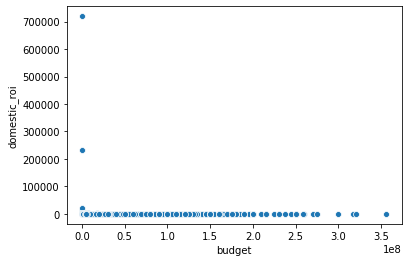

In [252]:
sns.scatterplot(x=movies_df['budget'], y=movies_df['domestic_roi']);